In [140]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import os
import pickle

In [77]:
%run Modeling_Utils.ipynb

## Load Data

In [78]:
load_data = LoadData()
PM_data = load_data.load_PM_data()
Rain_data = load_data.load_Rain_data()

## Pre-processing

In [79]:
# Start with rain data
rain_TS = pd.concat([value.set_index('Date') for value in Rain_data.copy().values()], axis=0).fillna(0).rename(columns={'73T':'Rain_73T'})
rain_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot:xlabel='Date'>

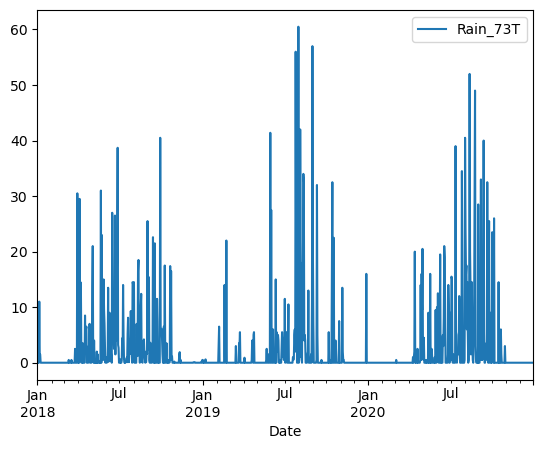

In [80]:
rain_TS.plot()

In [81]:
scope_year = [2018, 2019, 2020]
PM_TS = station_data_TS(PM_data, '73T', scope_year=scope_year)
PM_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2018-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM_73T  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot:xlabel='Date'>

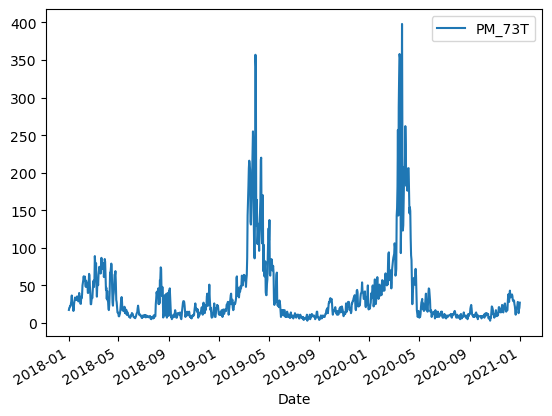

In [82]:
PM_TS.plot()

In [83]:
Data = pd.concat([rain_TS, PM_TS], axis=1)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1092 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


In [84]:
Data[Data['PM_73T'].isna()]

,Rain_73T,PM_73T
Date,,
2018-06-29,2.7,NaN
2019-06-29,0.5,NaN
2020-02-29,0.0,NaN
2020-06-29,0.0,NaN


<AxesSubplot:xlabel='Date'>

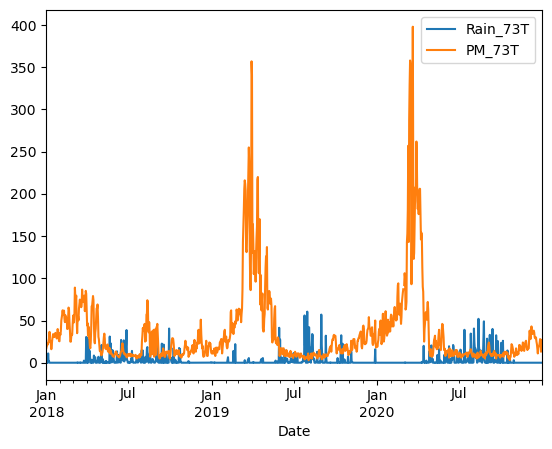

In [85]:
Data.plot()

In [86]:
# Fill nan on PM
Data['PM_73T'] = Data['PM_73T'].interpolate('linear')
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1096 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


<AxesSubplot:xlabel='Date'>

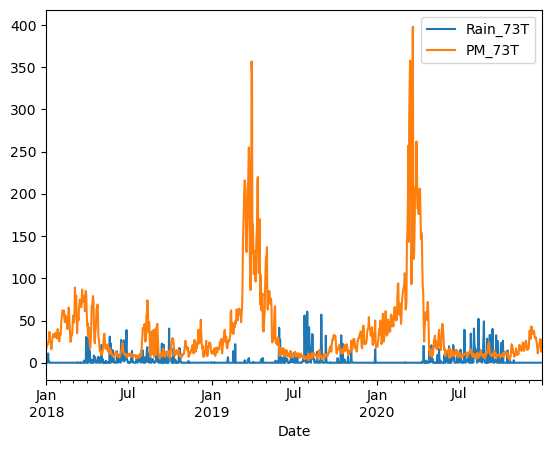

In [87]:
Data.plot()

In [130]:
Data['Date_num'] = np.arange(Data.shape[0])
Data

,Rain_73T,PM_73T,Date_num
Date,,,
2018-01-01,7.5,17.333333,0
2018-01-02,0.0,20.222222,1
2018-01-03,5.5,20.555556,2
2018-01-04,0.0,22.555556,3
2018-01-05,11.0,22.444444,4
...,...,...,...
2020-12-27,0.0,27.000000,1091
2020-12-28,0.0,13.000000,1092
2020-12-29,0.0,18.000000,1093


In [144]:
# X = Data['Rain_73T'].copy().to_numpy()
# X = Data['Date_num'].copy().to_numpy()
X = Data[['Date_num', 'Rain_73T']].copy().to_numpy()
y = Data['PM_73T'].copy().to_numpy()
portion = 0.8
dim = 2
X_train, X_test = X[:int(X.shape[0] * portion)].reshape(-1, dim), X[int(X.shape[0] * portion):].reshape(-1, dim)
y_train, y_test = y[:int(y.shape[0] * portion)].reshape(-1, 1), y[int(y.shape[0] * portion):].reshape(-1, 1)

In [132]:
Meta_Data = Data.reset_index()
train_df = Meta_Data.iloc[:int(Meta_Data.index.shape[0] * 0.8)]
test_df = Meta_Data.iloc[int(Meta_Data.index.shape[0] * 0.8):]

In [133]:
# train_df.to_csv('./TS_Data_train.csv', index=False)
# test_df.to_csv('./TS_Data_test.csv', index=False)

## Descriptive statistic for regression

Text(0, 0.5, 'PM2.5')

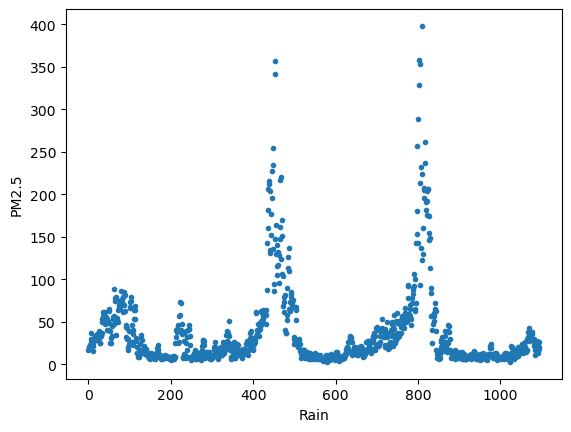

In [134]:
plt.plot(X, y, '.')
plt.xlabel('Rain')
plt.ylabel('PM2.5')

PearsonRResult(statistic=-0.008153541613138568, pvalue=0.7874474424863012)


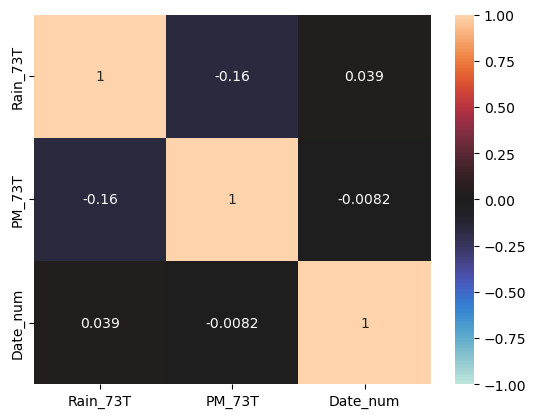

In [135]:
corr_mat = Data.corr()
print(stats.pearsonr(X, y))
sns.heatmap(corr_mat, annot=True, vmax=1, vmin=-1, center=0)
plt.show()

## Modelling on Orange

## Result

In [148]:
def plot_regression(X_train, y_train, X_test, y_test, model_path):
    regrssor = pickle.load(open(model_path, 'rb'))
    y_pred_test = regrssor.predict(X_test)
    y_pred_train = regrssor.predict(X_train)
    # Train fitting
    if X_train.shape[1] > 1:
        for i in range(X_train.shape[1]):
            plt.plot(X_train[:, i], y_pred_train, '.', label='Prediction')
            plt.plot(X_train[:, i], y_train, '.', label='Actual')
            plt.ylabel('PM 2.5')
            plt.xlabel('Rain volume')
            plt.title(f'Input: {regrssor.domain[i].name}')
            plt.legend()
            plt.grid()
            plt.pause(0.0001)
            plt.clf()
    else:
        plt.plot(X_train[:, 0], y_pred_train, '.', label='Prediction')
        plt.plot(X_train[:, 0], y_train, '.', label='Actual')
        plt.ylabel('PM 2.5')
        plt.xlabel('Rain volume')
        plt.title(f'Input: {regrssor.domain[0].name}')
        plt.legend()
        plt.grid()
        
  
    
    plt.figure()
    if X_test.shape[1] > 1:
        for i in range(X_test.shape[1]):
            plt.plot(X_test[:, i], y_pred_test, '.', label='Prediction')
            plt.plot(X_test[:, i], y_test, '.', label='Actual')
            plt.ylabel('PM 2.5')
            plt.xlabel('Rain volume')
            plt.title(f'Input: {regrssor.domain[i].name}')
            plt.legend()
            plt.grid()
            plt.pause(0.0001)
            plt.clf()
    
    else:
        plt.plot(X_test[:, 0], y_pred_test, '.', label='Prediction')
        plt.plot(X_test[:, 0], y_test, '.', label='Actual')
        plt.ylabel('PM 2.5')
        plt.xlabel('Rain volume')
        plt.title(f'Input: {regrssor.domain[0].name}')
        plt.legend()
        plt.grid()
        
    plt.show()


In [149]:
model_path = './Model/Linear_regression_Rain_Date.pkcls'
regress_1 = pickle.load(open(model_path, 'rb'))

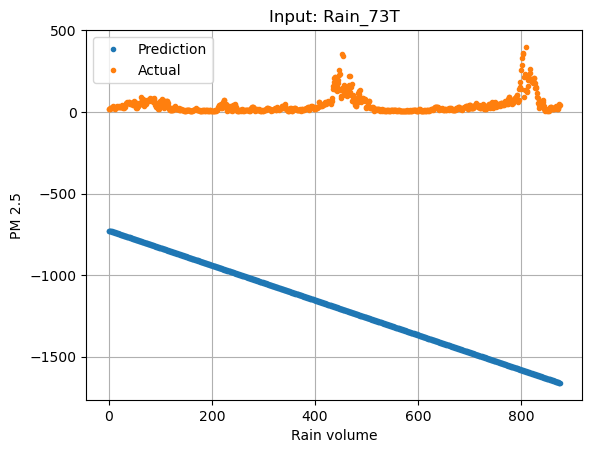

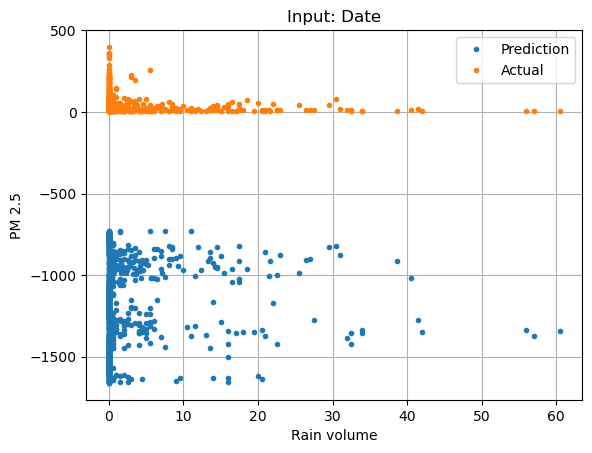

<Figure size 640x480 with 0 Axes>

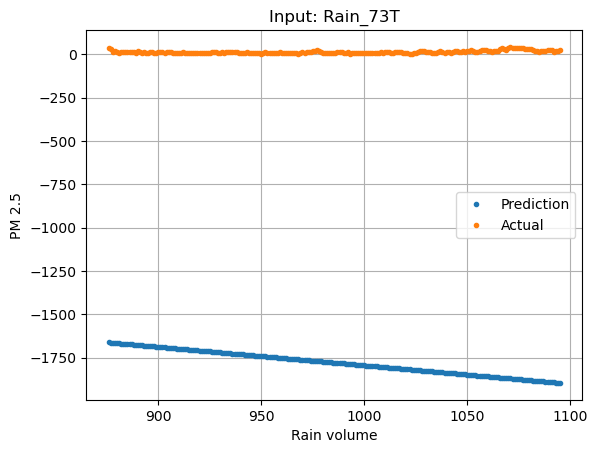

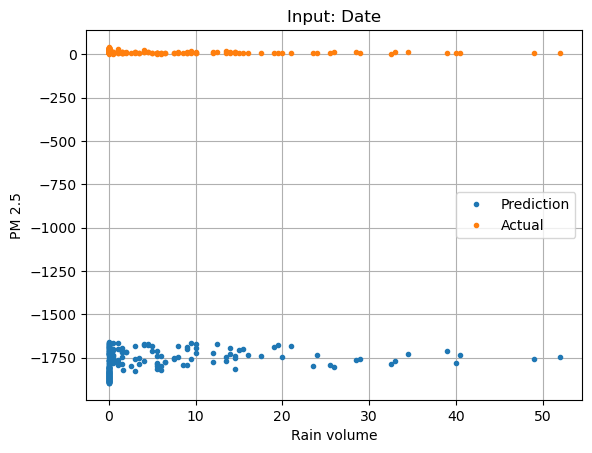

<Figure size 640x480 with 0 Axes>

In [150]:
plot_regression(X_train, y_train, X_test, y_test, model_path)